# In the name of God
# Machine Learning for Bioinformatics (Spring 1400)
# HW4 - CNN

# Student Info

## Full Name: Amin Ravanbakhsh

## Student Number: 96109725

## Don't forget to change this file name to HW4_{student number}.ipynb


In [1]:
########################## P0 ##########################
# README                                               #
########################################################
# You must fill the parts like this that surrounded by comments
########################## END #########################

# Imports

In [60]:
d_path = '/content/drive/MyDrive/ML_for_BIO/hws/hw4/'

In [61]:
RUN_LOCAL = False  # if you want to run this on colab, set this to False

In [62]:
# https://github.com/jacobgil/pytorch-grad-cam
if not RUN_LOCAL:
    !pip install grad-cam
    !pip install ttach

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
if not RUN_LOCAL:
    from google.colab import drive
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib.pyplot import imshow

# Configs

In [64]:
%matplotlib inline

In [65]:
BATCH_SIZE = 32
DATA_LOADER_KWARGS = {
    'batch_size': BATCH_SIZE, 
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 0,
}

RGB_MEANS = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]

In [66]:
DEVICE = None
########################## P1 ##########################
# check if gpu is available then put DEVICE to cuda:0  #
# else DEVICE is equal to cpu.                         #
########################################################
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
########################## END #########################
DEVICE

Running on the GPU


device(type='cuda', index=0)

# Data

## Load from Google Drive (if you want to run code on colab)

First create a folder named "ML for Bio - Spring 1400" in your google drive root and copy the content of [this link](https://drive.google.com/drive/folders/1X53xvmmS3avr6py7Cf1LUq8DSA1EvNpC?usp=sharing) to it.

Make sure you do this correctly and the next cell runs with no error.

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
#don't run this cell

# if not RUN_LOCAL:
#     # Load data from google drive
#     drive.mount('/content/drive', force_remount=True)

#     # Don't change this, you must put the data here in your Google Drive
#     # FOLDERNAME = 'ML\ for\ Bio\ -\ Spring\ 1400/brain-tumor-dataset'
#     FOLDERNAME = 'MyDrive/ML_for_BIO/hws/hw4/brain-tumor-dataset'


#     %cd drive/My\ Drive
#     %cp -r $FOLDERNAME ../../
#     %cd ../../brain-tumor-dataset
#     !unzip -q dataset.zip
#     !rm dataset.zip
#     %cd ..

In [12]:
# %cd /content/drive/MyDrive/ML_for_BIO/hws/hw4/
# !unzip -q dataset.zip
# !rm dataset.zip

## Local Data

If you want to run the code locally, download the [dataset.zip](https://drive.google.com/file/d/158VyFbTPLHE_uN2yXvMtalSqdD2mdd5r/view?usp=sharing) and extract it in 'brain-tumor-dataset' folder besides your code. it must has a structure like below:

```
HW4_{student number}.ipynb
brain-tumor-dataset/
    no/
    yes/
```

## Create DataLoaders

In [69]:
transforms = []
########################## P2 ##########################
# Create a list of torchvision.transforms to:          #
# 1- Resize the image to 256x265 pixels                #
# 2- Center Crop the image to 224x224 pixels           #
# 3- Convert To Tensor                                 #
# 4- Normalize the tensor with RGB_MEANS and RGB_STD   #
########################################################
resize_transform = torchvision.transforms.Resize((256, 256))
center_crop_transform = torchvision.transforms.CenterCrop((224, 224))
convert_transfomr = torchvision.transforms.ToTensor()
normalize_transform = torchvision.transforms.Normalize(RGB_MEANS, RGB_STD)
transforms = [resize_transform, center_crop_transform, convert_transfomr, normalize_transform]
########################## END #########################
#done

transforms = torchvision.transforms.Compose(transforms)
transforms

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [70]:
train_dataset, val_dataset, test_dataset = None, None, None
all_dataset = torchvision.datasets.ImageFolder(d_path, transform=transforms)
########################## P3 ##########################
# First split the all_dataset into three datasets with:#
# 70% Train, 20% Validation, 10% Test.                 #
# There is a function in torch.utils for this purpose. #
########################################################
data_len = len(all_dataset)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(all_dataset,[int(data_len*0.7), int(data_len*0.2), int(data_len*0.1)])
########################## END #########################
#done

train_loader = DataLoader(train_dataset, **DATA_LOADER_KWARGS)
val_loader = DataLoader(val_dataset, **DATA_LOADER_KWARGS)
test_loader = DataLoader(test_dataset, **DATA_LOADER_KWARGS)

print('Train Classes Dist:', np.bincount(np.array(all_dataset.targets)[train_dataset.indices]))
print('Val Classes Dist:  ', np.bincount(np.array(all_dataset.targets)[val_dataset.indices]))
print('Test Classes Dist: ', np.bincount(np.array(all_dataset.targets)[test_dataset.indices]))

Train Classes Dist: [1056 1044]
Val Classes Dist:   [293 307]
Test Classes Dist:  [151 149]


In [71]:
input_shape = tuple(all_dataset[0][0].shape)
num_classes = len(all_dataset.classes)

print('Input Shape =', input_shape)
print('Num of Classes =', num_classes)

Input Shape = (3, 224, 224)
Num of Classes = 2


In [ ]:
# #to see data from loader view
# train_tuple = tuple(train_loader)
# val_tuple = tuple(val_loader)
# test_tuple = tuple(test_loader)

## Visualizing

In [72]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor normalized image of size (C, H, W).
        Returns:
            Tensor: UnNormalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unnormalize = UnNormalize(RGB_MEANS, RGB_STD)

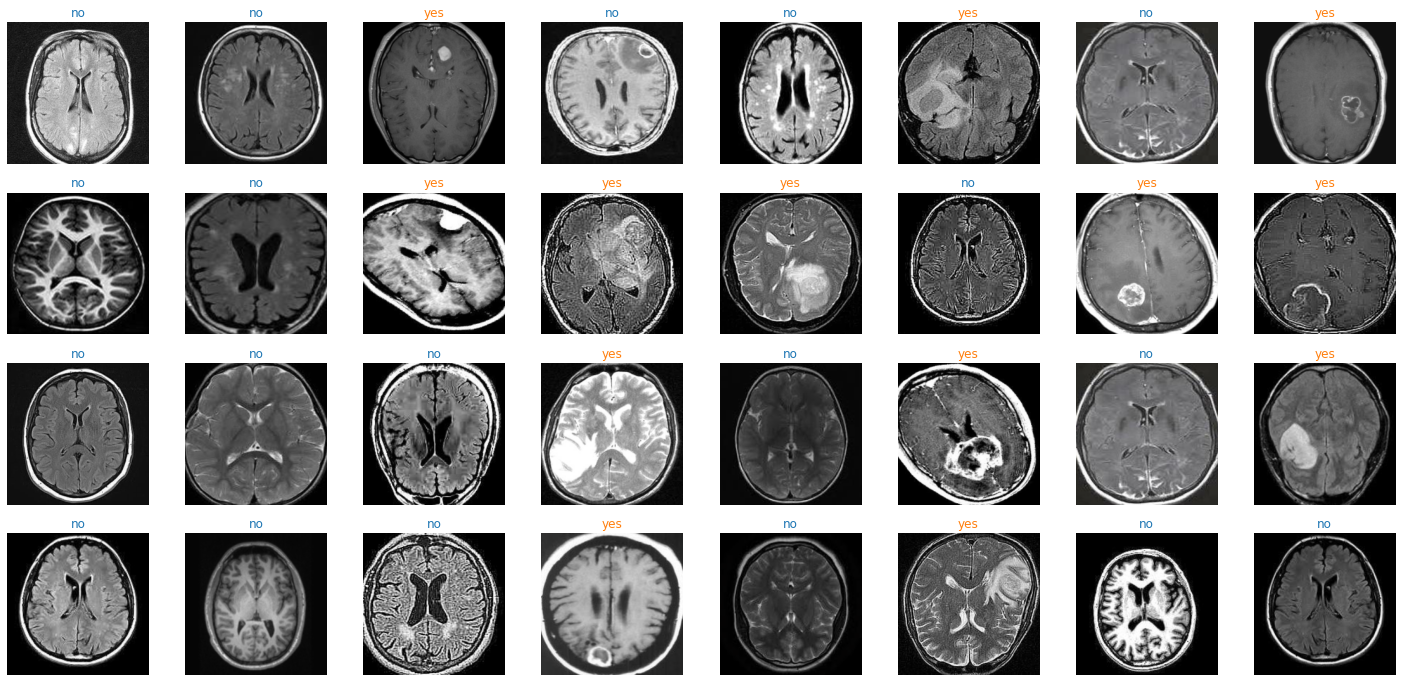

In [73]:
vis_num_images = 32
vis_images_per_row = 8

np.random.seed(6)
vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
vis_images, vis_labels = [], []
for i in vis_image_indexes:
    new_image, new_label = all_dataset[i]
    vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))
    vis_labels.append(new_label)

fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)

for i in range(vis_num_images):
    ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
    ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
    ax.axis('off')
    ax.imshow(vis_images[i])

plt.show()

# Train & Test Methods

## Train

In [74]:
def train(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_log = []
    test_log = []
    plt.figure(figsize=(16, 8))

    for epoch in range(1, num_epochs+1):
        train_loss = []
        model.train()
        for inputs, targets in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.get_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))

        test_loss = []
        model.eval()
        with torch.no_grad():                
            for inputs, targets in tqdm(test_loader, desc='Validation', leave=False):         
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = model.get_loss(outputs, targets)
                test_loss.append(loss.item())
        test_log.append(np.mean(test_loss))

        plt.clf()
        plt.title(f'Epoch {epoch}/{num_epochs}')
        plt.plot(range(1, epoch+1), train_log, color='C0', label='Train')
        plt.plot(range(1, epoch+1), test_log, color='C1', label='Val')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    plt.close()

## Test

In [75]:
def test(model, data_loader):
    y_true, y_pred = [], []

    with torch.no_grad():                
        for inputs, targets in tqdm(data_loader, desc='Predicting', leave=False):         
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            if type(outputs) is tuple: outputs = outputs[-1]
            outputs = outputs.detach().cpu().numpy()

            y_true += targets.detach().cpu().numpy().tolist()
            y_pred += np.argmax(outputs, axis=-1).tolist()

    print(classification_report(y_true, y_pred, target_names=all_dataset.classes))

# Model Definition

In [76]:
class ConvClassifier(nn.Module):
    def __init__(self, input_shape, num_classes, convs, fcs, conv_drop_rate=None, fc_drop_rate=None):
        """
        Args:
            input_shape: the dimension of the input image.
            num_classes: number of output classes.
            convs: it's 'vgg16' or a list of tuples with these info\:
                (out_channels, kernel_size, stride, padding, has_pooling), the first four are
                the configuration for creating a Conv2d layer and if has_pooling was True, you
                must add a MaxPool2d after the Conv2d.
            fcs: a list of integers representing number of Linear neurons in each layer
            conv_drop_rate: float(0-1), drop rate used for Conv2d layers
            fc_drop_rate: float(0-1), drop rate used for Linear layers
        """
        super(ConvClassifier, self).__init__()

        # Convolution Layers
        self.conv_layers = None
        if convs == 'vgg16':
            vgg16_pretrained = None
            ########################## P4 ##########################
            # set `vgg16_pretrained` to pretrained vgg16 model with#
            # batch normalization                                  #
            ########################################################
            vgg16_pretrained = torchvision.models.vgg16_bn(pretrained=True)
            #done
            ########################## END #########################
            self.conv_layers = vgg16_pretrained.features

        elif type(convs) is list:
            conv_layers = []
            ########################## P5 ##########################
            # for each item in `convs` add these 3-5 items to      #
            # `conv_layers`:                                       #
            # 1- nn.Conv2d                                         #
            # 2- nn.BatchNorm2d                                    #
            # 3- nn.ReLU                                           #
            # 4- nn.Dropout if `conv_drop_rate` is not None        #
            # 5- nn.MaxPool2d(2, 2) if has_pooling is True         #
            ########################################################

            # RGB are frist channels
            last_channel_num = 3
            for conv_item in convs:
                out_channel_num, kernel_size, stride, padding, has_pooling = conv_item
                conv_layers.append(nn.Conv2d(in_channels=last_channel_num, out_channels=out_channel_num, kernel_size= kernel_size, stride = stride))
                conv_layers.append(nn.BatchNorm2d(out_channel_num))
                conv_layers.append(nn.ReLU())
                if not conv_drop_rate == None:
                    conv_layers.append(nn.Dropout(p=conv_drop_rate))
                if has_pooling:
                    conv_layers.append(nn.MaxPool2d(2,2))
                last_channel_num = out_channel_num

            #done
            ########################## END #########################
            self.conv_layers = nn.Sequential(*conv_layers)

        else:
            raise Exception(f'Wrong value for parameter `convs`: {convs}')
        # Get the output shape of last conv layer
        convs_output_shape = self.conv_layers(torch.randn(1, *input_shape)).shape[1:]
        

        # Fully Connected Layers
        fc_layers = []
        ########################## P6 ##########################
        # first add a nn.Flatten to `fc_layers` then for each  #
        # value in `fcs` add these 3-4 items to `fc_layers`:   #
        # 1- nn.Linear                                         #
        # 2- nn.BatchNorm1d                                    #
        # 3- nn.ReLU                                           #
        # 4- nn.Dropout if `fc_drop_rate` is not None          #
        # in the end add a nn.Linear for the final output with #
        # `num_classes` neurons and a nn.Softmax after it.     #
        ########################################################
        fc_layers.append(nn.Flatten())

        last_layer_size = 1
        for val in convs_output_shape:
            last_layer_size *= val

        for fc_size in fcs:
            fc_layers.append(nn.Linear(last_layer_size, fc_size))
            fc_layers.append(nn.BatchNorm1d(fc_size))
            fc_layers.append(nn.ReLU())
            if not fc_drop_rate == None:
                fc_layers.append(nn.Dropout(p=fc_drop_rate))

            last_layer_size = fc_size
        
        fc_layers.append(nn.Linear(last_layer_size, num_classes))
        #done
        ########################## END #########################
        self.fc_layers = nn.Sequential(*fc_layers)

        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, x):
        output = None
        ########################## P7 ##########################
        # generate the output using created variables.         #
        ########################################################
        output = self.conv_layers(x)
        output = self.fc_layers(output)
        # output = self.cross_entropy(output)
        #done
        ########################## END #########################
        return output

    def get_loss(self, outputs, targets):
        loss = None
        ########################## P8 ##########################
        # calculate the loss using `self.cross_entropy`        #
        ########################################################
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, targets)
        #done
        ########################## END #########################
        return loss

# Vanilla VGG16 (no pretrain)

## Create Model

In [101]:
vgg16 = None
########################## P9 ##########################
# By using the `ConvClassifier` class create vgg16.    #
# in this part you must write the layers specifications#
# yourself (use convs = list of tuples).               #
# Change the drop rates to get best result in 10 epochs#
########################################################

convs_costume1 = [
    (64, (3,3), (1,1), (1,1),False),
    (64, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (256, (3,3), (1,1), (1,1), False)  
]

convs_costume2 = [
    (64, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), False),
    (256, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), False)                    
]

convs_costume3 = [
    (256, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), False)         
]

convs_costume4 = [
    (128, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), True),
    (64, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), True)  
]

convs_costume5 = [
    (10, (3,3), (2,2), (0,0), False),
    (5, (3,3), (2,2), (1,1), True)
]

num_classes = 2
convs = convs_costume5
fcs = [32, 32, 10]
conv_drop_rate = 0.2
fc_drop_rate = 0.2
vgg16 = ConvClassifier(input_shape, num_classes, convs, fcs, conv_drop_rate, fc_drop_rate)

#done
########################## END #########################

vgg16.to(DEVICE)
vgg16

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3645, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, 

## Train

In [105]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-3)

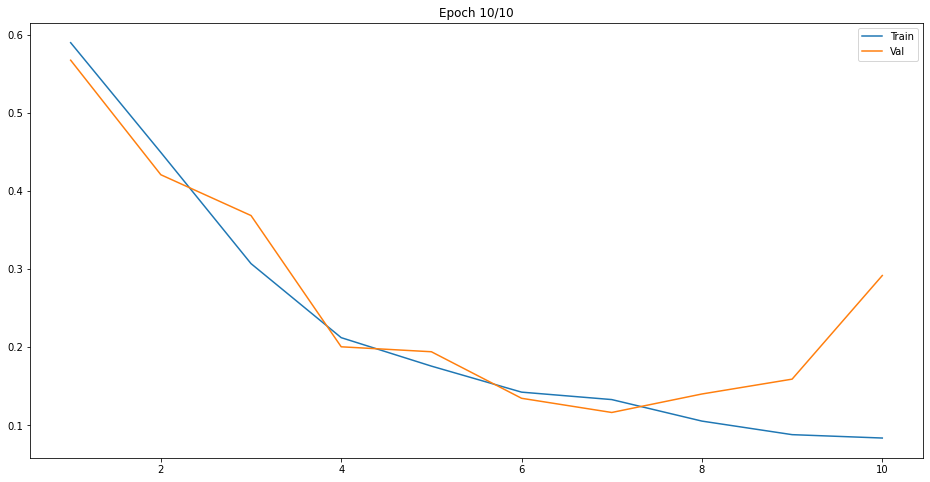

In [106]:
train(vgg16, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [107]:
test(vgg16, train_loader)

              precision    recall  f1-score   support

          no       0.86      1.00      0.93      1056
         yes       1.00      0.84      0.91      1044

    accuracy                           0.92      2100
   macro avg       0.93      0.92      0.92      2100
weighted avg       0.93      0.92      0.92      2100



In [108]:
test(vgg16, val_loader)

              precision    recall  f1-score   support

          no       0.78      0.99      0.87       293
         yes       0.99      0.73      0.84       307

    accuracy                           0.86       600
   macro avg       0.88      0.86      0.85       600
weighted avg       0.89      0.86      0.85       600



In [109]:
test(vgg16, test_loader)

              precision    recall  f1-score   support

          no       0.81      0.99      0.89       151
         yes       0.99      0.77      0.86       149

    accuracy                           0.88       300
   macro avg       0.90      0.88      0.88       300
weighted avg       0.90      0.88      0.88       300



## CAM (Class Activation Map)

In [102]:
def CAM(model, target_layer):
    fig = plt.figure(figsize=(25, 12))
    gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)
    ########################## P10 #########################
    # Create the same grid of images as "Visualizing" part #
    # but you must add CAM overlay to them too. use        #
    # `GradCAMPlusPlus` and `show_cam_on_image` for this.  #
    ########################################################
    np.random.seed(6)
    vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
    vis_images, vis_labels = [], []
    GCPP_datas = []
    grad_images = []
    
    GradCamPP = GradCAMPlusPlus(model=model, target_layer=target_layer)
        
    for i in vis_image_indexes:
        new_image, new_label = all_dataset[i]
        vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))

        new_img_unsq = new_image.unsqueeze(0).to(DEVICE)
        grayscale_cam = GradCamPP(input_tensor = new_img_unsq)
        GCPP_datas.append(grayscale_cam.squeeze())
        grad_images.append(show_cam_on_image(vis_images[-1], GCPP_datas[-1]))
        vis_labels.append(new_label)

    for i in range(vis_num_images):
        ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
        ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
        ax.axis('off')
        grad_images[i] = show_cam_on_image(vis_images[i], GCPP_datas[i])
        ax.imshow(grad_images[i])

    #done
    ########################## END #########################
    plt.show()

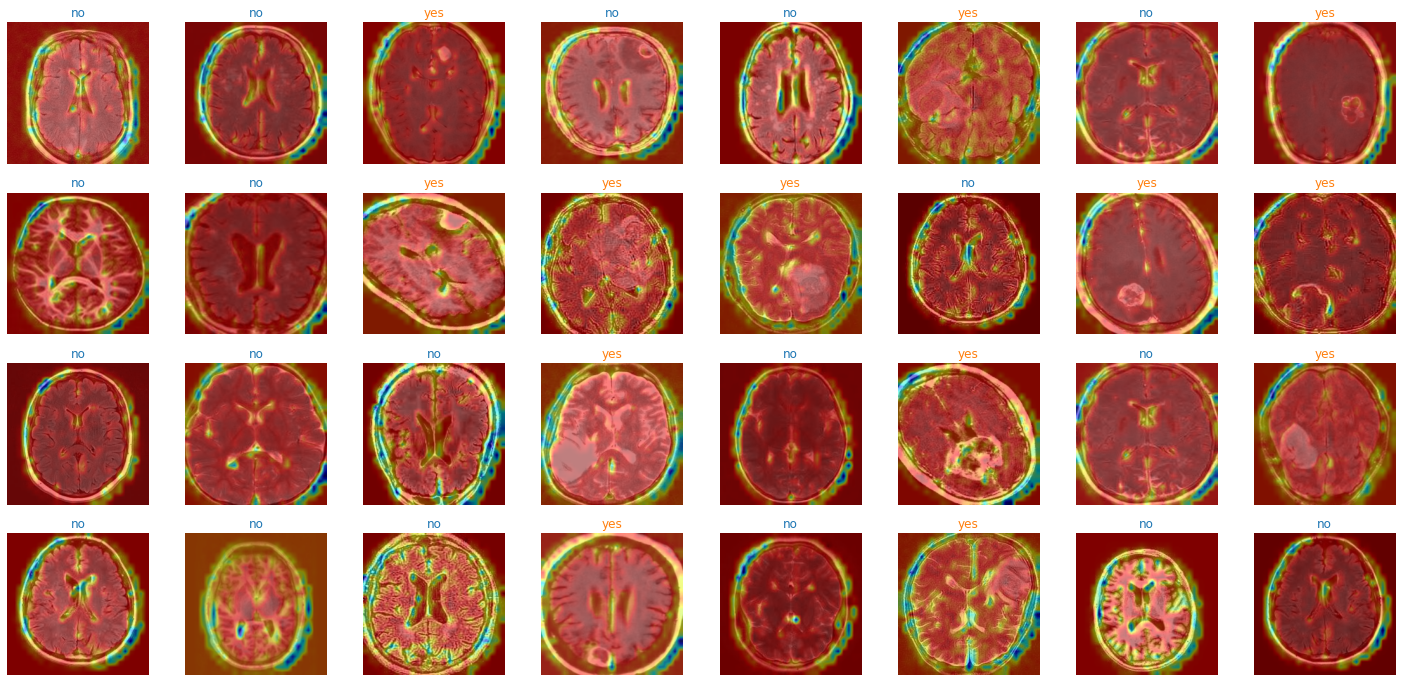

In [111]:
CAM(vgg16, vgg16.conv_layers[-1])

# Transfer Learning

## Create Model

In [85]:
vgg16_imagenet = None
########################## P11 #########################
# Like "P9" but use convs = 'vgg16' this time.           #
########################################################
num_classes = 2
convs = 'vgg16'
fcs = [32, 32, 10]
conv_drop_rate = 0.2
fc_drop_rate = 0.2
vgg16_imagenet = ConvClassifier(input_shape, num_classes, convs, fcs, conv_drop_rate, fc_drop_rate)
#done
########################## END #########################

vgg16_imagenet.to(DEVICE)
vgg16_imagenet

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

## Train

In [86]:
########################## P12 #########################
# Change the Learning Rate and compare the results.    #
# write your observation and its reasons in the next   #
# cell.                                                #
########################################################
optimizer = torch.optim.Adam(vgg16_imagenet.parameters(), lr=1e-2)
########################## END #########################

P12 Answer:


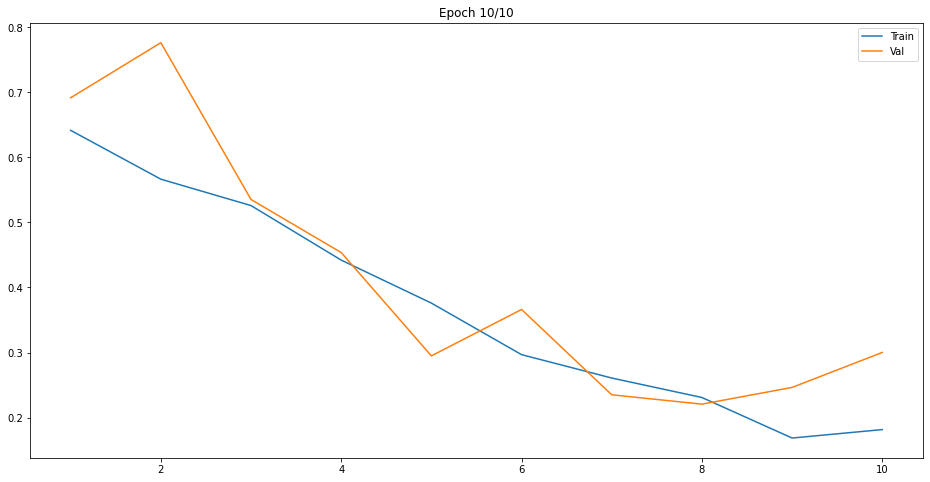

In [87]:
train(vgg16_imagenet, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [88]:
test(vgg16_imagenet, train_loader)

              precision    recall  f1-score   support

          no       0.99      0.80      0.89      1056
         yes       0.83      0.99      0.91      1044

    accuracy                           0.90      2100
   macro avg       0.91      0.90      0.90      2100
weighted avg       0.91      0.90      0.90      2100



In [89]:
test(vgg16_imagenet, val_loader)

              precision    recall  f1-score   support

          no       0.99      0.77      0.87       293
         yes       0.82      0.99      0.90       307

    accuracy                           0.88       600
   macro avg       0.90      0.88      0.88       600
weighted avg       0.90      0.88      0.88       600



In [90]:
test(vgg16_imagenet, test_loader)

              precision    recall  f1-score   support

          no       0.99      0.75      0.85       151
         yes       0.80      0.99      0.88       149

    accuracy                           0.87       300
   macro avg       0.89      0.87      0.87       300
weighted avg       0.89      0.87      0.87       300



## CAM (Class Activation Map)

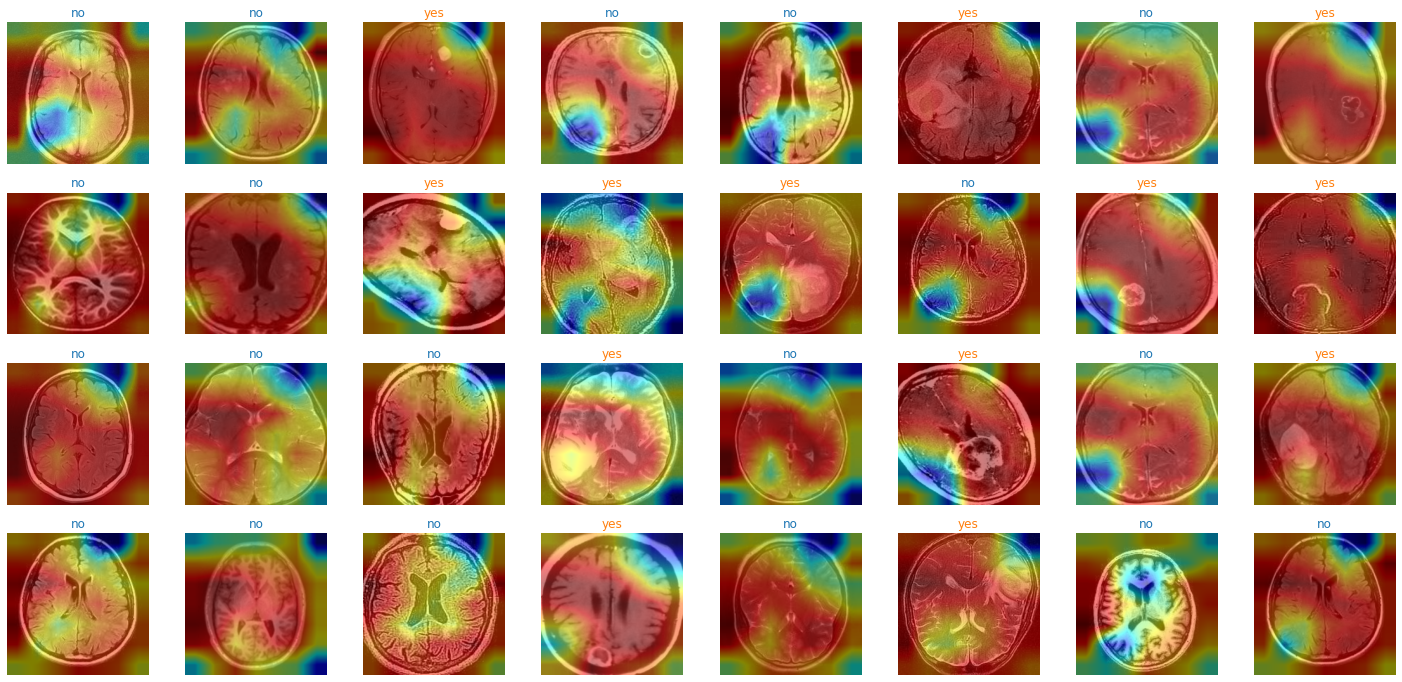

In [104]:
CAM(vgg16_imagenet, vgg16_imagenet.conv_layers[-1])

# Questions
Answer the following questions:

## P13:
<div dir="rtl">
دلایلی که باعث بهبود نتیجه با استفاده از Transfer Learning شده‌اند، چیست؟
</dir>

<div dir="rtl">
زمانی که از transfer learing استفاده می‌کنیم از لایه‌هایی استفاده می‌کنیم که از قبل مقداری آموزش دیده‌اند و ما تنها آن‌ها را به صورتی در می‌آوریم که برای مسئله ما مناسب باشند.

با توجه به این که شبکه vgg16 به صورت یک شبکه معتبر است احتمالا استفاده از لایه‌های از قبل آموزش دیده بهتر خواهند بود. همچنین شبکه‌ای که توسط ما ساخته شده بسیار کوچک تر از vgg16 می باشد و پیچیدگی پایین تر آن باعث می‌شود به اندازه شبکه vgg16 توانایی یادگیری نداشته باشد.
</div>

## P14:

<div dir="rtl">
با توجه به خروجی CAM، آیا شبکه به قسمت درستی از عکس نگاه میکند؟ در هر یک از لیبل‌های yes و no شبکه به کجای عکس نگاه می‌کند؟
</div>

<div dir="rtl">
در عکس‌هایی که label آن‌ها no است قسمتی از مغز در بیشتر عکس‌ها مورد بررسی قرار گرفته است که احتمالا سالم بودن آنها را توجیه می‌کند و در عکس هایی که label آن‌ها yes هست بعضی وقتا به آن قسمت اشاره شده است. بعضی از عکس‌ها هم خیلی دقیق نیستند.

احتمالا با بالا بردن مقدار احتمال dropout می‌توانیم نتایج بهتری نیز بگیریم
</div>